In [1]:
import numpy as np
import numpy.random as npr
import numba as nb
import math as math
tol = 1e-20
exp = np.exp
log = np.log
pi = np.pi
sin = np.sin
sqrt = np.sqrt

@nb.njit(nb.f8(nb.f8), fastmath=True)
def slog(x):
    return np.log(x + tol)

@nb.njit(nb.f8(nb.f8, nb.f8), fastmath=True)
def sdiv(x, y):
    return x/(y + tol)

@nb.njit(nb.f8(nb.f8, nb.f8, nb.f8, nb.f8), fastmath=True)
def gen_U(w1, w2, w3, gamma):
    V = npr.rand()
    W_p = npr.rand()
    if gamma >= 1:
        if (V < sdiv(w1, w1+w2)):
            U = abs(npr.randn()) / sqrt(gamma)
        else:
            U = pi * (1 - W_p**2)
    else:
        if (V < sdiv(w3,w3 + w2)):
            U = pi * W_p
        else:
            U = pi * (1 - W_p**2)
    return U

@nb.njit(nb.f8(nb.f8), fastmath=True)
def sinc(x):
    return sdiv(np.sin(x), x)

@nb.njit(nb.f8(nb.f8, nb.f8), fastmath=True)
def ratio_B(x, sigma):
    return sdiv(sdiv(sinc(x), sinc(sigma*x)**sigma),
            sinc((1-sigma)*x)**(1-sigma))

@nb.njit(nb.f8(nb.f8, nb.f8), fastmath=True)
def zolotarev(u, sigma):
    expn = min(sdiv(1, 1-sigma), 50.0)
    x = sdiv(sin(sigma*u)**sigma * sin((1-sigma)*u)**(1-sigma), sin(u))**expn
    return x

@nb.njit(nb.f8[:](nb.f8, nb.f8, nb.f8, nb.i4), fastmath=True)
def etstablernd(V0, alpha, tau, n):

    # check params
    if alpha <= 0 or alpha >= 1:
        raise ValueError('alpha must be in ]0,1[')
    if tau < 0:
        raise ValueError('tau must be >= 0')
    if V0 <= 0:
        raise ValueError('V0 must be > 0')

    lambda_alpha = tau**alpha * V0

    # Now we sample from an exponentially tilted distribution of parameters
    # sigma, lambda, as in (Devroye, 2009)
    gamma = lambda_alpha * alpha * (1-alpha)

    xi = 1/pi *((2+sqrt(pi/2)) * sqrt(2*gamma) + 1) # Correction in Hofert
    psi = 1/pi * exp(-gamma * pi**2/8) * (2 + sqrt(pi/2)) * sqrt(gamma * pi)
    w1 = xi * sqrt(pi/2/gamma)
    w2 = 2 * psi * sqrt(pi)
    w3 = xi * pi
    b = (1-alpha)/alpha

    samples = np.zeros(n)
    for i in range(n):
        while True:
            # generate U with density g*/G*
            while True:
                # Generate U with density proportional to g**
                U = gen_U(w1, w2, w3, gamma)
                while U >= pi:
                    U = gen_U(w1, w2, w3, gamma)

                assert U > 0
                assert U < pi

                W = npr.rand()
                zeta = sqrt(ratio_B(U, alpha))

                z = sdiv(1, 1 - (1 + sdiv(alpha*zeta, sqrt(gamma)))**sdiv(-1, alpha))
                rho = 1
                rho = pi * exp(min(-lambda_alpha * (1-zeta**(-2)), 1e+2)) \
                        * (xi * exp(-gamma*U**2/2) * (gamma>=1) \
                        + sdiv(psi, sqrt(pi-U)) \
                        + sdiv(xi * (gamma<1),
                            (1 + sqrt(pi/2))*sdiv(sqrt(gamma),zeta)+z))

                if W*rho <= 1:
                    break

            # Generate X with density proportional to g(x, U)
            a = zolotarev(U, alpha)
            m = sdiv(b,a)**alpha * lambda_alpha
            delta = sqrt(m*sdiv(alpha, a))
            a1 = delta * sqrt(pi/2)
            a2 = a1 + delta # correction in Hofert
            a3 = sdiv(z, a)
            s = a1 + delta + a3 # correction in Hofert
            V_p = npr.rand()
            N_p = npr.randn()
            E_p = -log(npr.rand())

            if V_p < sdiv(a1, s):
                X = m - delta*abs(N_p)
            elif V_p < sdiv(a2, s):
                X = delta * npr.rand() + m
            else:
                X = m + delta + a3 * E_p

            if X >= 0:
                E = -slog(npr.rand())
                cond = (a*(X-m) + exp(1/alpha*slog(lambda_alpha)-b*slog(m)) \
                        *(sdiv(m, X)**b - 1) - (N_p**2/2) * (X<m) - E_p * (X>m+delta))
                if cond <= E:
                    break

        samples[i] = exp(1/alpha*log(V0) - b*slog(X)) # more stable than V0^(1/alpha) * X**(-b)

    return samples

In [2]:
def GGPsumrnd(eta, sigma, c, n):
    if sigma < 1e-8:
        S = np.zeros(n)
        for i in range(n):
            S[i] = npr.gamma(eta, 1./c)
        return S
    else:
        return etstablernd(eta/sigma, sigma, c, n)

In [3]:
def GBFRYsumrnd(eta, tau, sigma, c, n):
    S = GGPsumrnd(eta/c**sigma, sigma, c, n)
    for i in range(n):
        K = npr.poisson(eta/tau)
        for _ in range(K):
            S[i] += npr.gamma(1-sigma, 1)/(npr.beta(tau, 1)*c + 1e-20)
    return S

# MCMC

In [82]:
import numba as nb

def logit(x, lb=0., ub=1.):
    z = (x-lb)/(ub-lb)
    return np.log(z) - np.log(1-z)

def sigmoid(x, lb=0., ub=1.):
    return lb + (ub-lb)/(1 + np.exp(-x))

def hill_estimate(x, k):
    x = np.sort(abs(x))[::-1]
    log_x = np.log(x + 1e-10)[:k]
    avesumlog = np.cumsum(log_x)/np.arange(1, k+1)
    xihat = (avesumlog - log_x)[1:]
    alphahat = 1./xihat
    return alphahat

In [138]:
from scipy import stats
z = GBFRYsumrnd(eta = 1, tau = 10, sigma = 0.6, c = 1, n = 50000)
epsilon = stats.norm.rvs(loc = 0, scale = 1, size = 50000)
y_new = np.sqrt(z)*epsilon

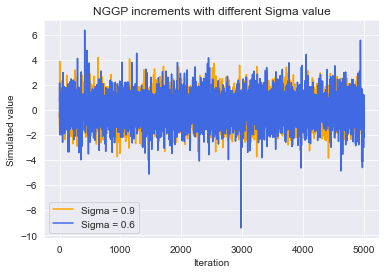

In [133]:
plt.plot(y_new, color = 'orange')
plt.plot(y_new2, color = 'royalblue')
plt.xlabel("Iteration")
plt.ylabel("Simulated value")
plt.legend(('Sigma = 0.9', 'Sigma = 0.6'))
plt.title('NGGP increments with different Sigma value')
plt.savefig('documents/thesis/generated_increments_sigma.png', dpi = 300)

In [84]:
import time
from Downloads.PComputePreq import log_lik_normal_particless
import multiprocessing as mp

#eta_var = phi[3]*phi[1]*phi[0]/(phi[1]+1 - phi[2])
#eta_fraction = phi[0]*phi[3]

def log_lik_normal_particles(phi, particles):
    
    #start_time = time.time()
    
    v = np.zeros((particles, 5000))
    
    for i in range(0, particles, 1):
        
        v[i, 0:5000] = GBFRYsumrnd(eta = phi[0]*phi[3], tau = phi[1]+1, sigma = phi[2], c = phi[3], n = 5000)
        
    llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))
    
    #print(time.time() - start_time, 's')
    
    return llk

#def log_lik_normal_p(phi):
    
    #start_time = time.time()
    
#    pool = mp.Pool(4)
          
#    v = np.matrix(pool.starmap(log_lik_normal_particless, [(phi, i) for i in range(0,300)]))
    
#    pool.close()  
        
#    llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))
    
    #print(time.time() - start_time, 's')
    
#    return llk

def fraction(phi, phi_new):
    
    llknew = log_lik_normal_particles(phi_new, 25)
    llkold = log_lik_normal_particles(phi, 25)
    
    numerator = llknew + log(stats.uniform.pdf(phi_new[0], loc = 0, scale = 10)) + log(stats.gamma.pdf(phi_new[1], a = 1, loc = 0, scale = 1)) + log(stats.uniform.pdf(phi_new[2], loc = 0, scale = 1)) + log(stats.gamma.pdf(phi_new[3], a = 0.1, loc = 0, scale = 0.1)) 
    
    denominator = llkold + log(stats.uniform.pdf(phi[0], loc = 0, scale = 10)) + log(stats.gamma.pdf(phi[1], a = 1, loc = 0, scale = 1)) + log(stats.uniform.pdf(phi[2], loc = 0, scale = 1)) + log(stats.gamma.pdf(phi[3], a = 0.1, loc = 0, scale = 0.1))
    
    logfrac = numerator-denominator
    
    return logfrac, llknew, llkold


def acceptance(phi, phi_new):
    
    fr = fraction(phi, phi_new)
    
    if fr[0] > 0:
        cond = True
        
    else:
        acc = np.random.uniform(0,1)
        cond = (acc < (np.exp(fr[0])))
        
    llknew = fr[1]
    llkold = fr[2]
    
    return cond, llknew, llkold 

In [85]:
import random as rd

def mhmcmc(K):
    
    
    start_time = time.time()
    
    #halpha = hill_estimate(y_new, 50)[15:].mean()
    
    out = np.zeros((K, 5))

    phi = np.zeros(4)
    
    phi[0] = 1 + stats.norm(0, 0.01).rvs(size = 1)
    phi[1] = 2 +  stats.norm(0, 0.01).rvs(size = 1)
    phi[2] = 0.6 + stats.norm(0, 0.01).rvs(size = 1)
    phi[3] = 1 + stats.norm(0, 0.01).rvs(size = 1)
    

    out[0, 0:4] = phi
    

    for k in range(1,K,1):
        
        
        
        
        #print(phi)

        
        lis = [1]
        
        choice = rd.choice(lis)
        
        phi_new = np.zeros(4)
        
        if choice == 1:         
            phi_new[0] = stats.norm(phi[0], 0.05).rvs(size = 1)
            phi_new[1] = stats.norm(phi[1], 1).rvs(size = 1)
            phi_new[2] = stats.norm(phi[2], 0.1).rvs(size = 1)
            phi_new[3] = stats.norm(phi[3], 0.5).rvs(size = 1)
        
        while phi_new[0] < 0 or phi_new[1] < 0 or phi_new[2] < 0 or phi_new[2] > 1 or phi_new[3] < 0:
            phi_new[0] = stats.norm(phi[0], 0.05).rvs(size = 1)
            phi_new[1] = stats.norm(phi[1], 1).rvs(size = 1)
            phi_new[2] = stats.norm(phi[2], 0.1).rvs(size = 1)
            phi_new[3] = stats.norm(phi[3], 0.5).rvs(size = 1)
            if phi_new[0] > 0 and phi_new[1] > 0 and phi_new[2] > 0 and phi_new[2] < 1 and phi_new[3] > 0:
                break
             
            
        if choice == 2: 
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 
            
        if choice == 3:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 

        if choice == 4:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1))
        
        #if phi_new[3] < 0:
        #    phi_new[3] = 0.0000000001
            
        
        #print(phi_new)
        #print(phi)
        
        #phi_new[0] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)    
            
      #  if choice == 2: 
        #phi_new[1] = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 1)
            
      #  if choice == 3:
        #phi_new[2] = stats.uniform.rvs(loc = 0, scale = 1, size = 1)

       # if choice == 4:
        #phi_new[3] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)
        
        

        acc = acceptance(phi, phi_new)
        #print(acc[1])
        #print(acc[2])
        
        #print('----------------------')

        if acc[0] is True:

            phi = phi_new 
            out[k, 4] = acc[1]

        else:

            phi = phi
            out[k, 4] = acc[2]

        out[k, 0:4] = phi

        if k == 1:
            print(1)
            print(time.time() - start_time, 's')
        
        if k == 10:
            print(10)
            print(time.time() - start_time, 's')
            
        if k == 50:
            print(50)
            print(time.time() - start_time, 's')
            
        if k == 100:
            print(100)
            print(time.time() - start_time, 's')
            
        if k == 200:
            print(200)
            print(time.time() - start_time, 's')
            
        if k == 300:
            print(300)
            print(time.time() - start_time, 's')
            
        if k == 400:
            print(400)
            print(time.time() - start_time, 's')
            
            
        if k == 1000:
            print(1000)
        if k == 4000:
            print(4000)
            
        if k == 8000:
            print(8000)
        
        
    print(time.time() - start_time, 's')
        
    return out


intc_final10_1 = mhmcmc(5000)

#c - 1, sigma - 0.1, tau - 0.2, var - 0.1 - tau was mixing very well 



1
1.7122149467468262 s
10
14.302685976028442 s
50
76.91016793251038 s
100
143.07781386375427 s
200
254.32212901115417 s
300
383.04879212379456 s
400
495.475252866745 s
1000


<ipython-input-84-c909d0175fb0>:18: RuntimeWarning: divide by zero encountered in log
  llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))


4000
5660.148216962814 s


In [86]:
intc_final10_2 = mhmcmc(5000)

1
1.440364122390747 s
10
14.191309213638306 s
50
75.70664620399475 s
100
127.46740412712097 s
200
227.13717103004456 s
300
340.437646150589 s
400
444.92008209228516 s
1000
4000


<ipython-input-84-c909d0175fb0>:18: RuntimeWarning: divide by zero encountered in log
  llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))


5236.688207864761 s


In [87]:
intc_final10_3 = mhmcmc(5000)

1
1.2367441654205322 s
10
13.591886043548584 s
50
60.39691519737244 s
100
113.15496802330017 s
200
201.23185420036316 s
300
274.772057056427 s
400
393.1816580295563 s
1000
4000
5963.775438070297 s


In [93]:
phi_111 = [1, 2, 0.6, 1]
log_lik_normal_particles(phi_111, 1000)

-5935.872727315026

In [55]:
aaxis = np.arange(1000)
plt.plot(aaxis, intc_test_4[:, 0]*intc_test_4[:, 3], 'forestgreen', aaxis, intc_test_4[:, 3], 'royalblue')
plt.axhline(1, color = 'black', label = 'True value of Eta')
plt.axhline(1, color = 'black', label = 'True value of Eta')

plt.legend(('Eta', 'C', 'True Value'))
plt.title('Eta, C MCMC trace plot')
plt.xlabel("Parameter Value")
plt.ylabel("Iteration")
#plt.show()
plt.savefig('documents/thesis/etactogether.png', dpi = 1000)

NameError: name 'intc_test_4' is not defined

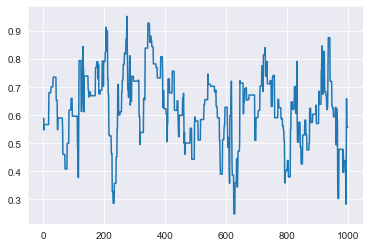

In [417]:
plt.plot(intc_test_6[:, 2])

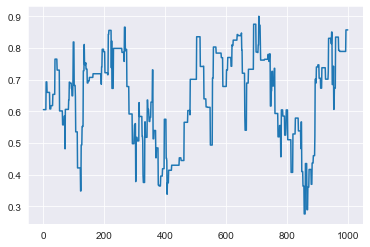

In [408]:
plt.plot(intc_test_4[:, 2])

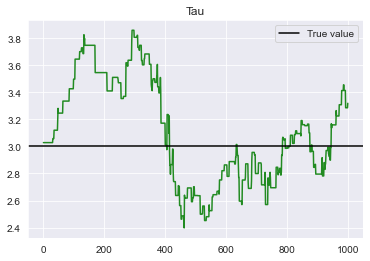

<Figure size 432x288 with 0 Axes>

In [203]:
plt.plot(intc_test_3[:, 1]+1, 'forestgreen')
plt.axhline(3, color = 'black', label = 'True value')
plt.legend()
plt.title('Tau')
plt.show()
plt.savefig('documents/thesis/tau05.png', dpi = 1000)

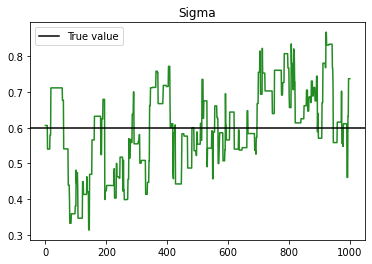

<Figure size 432x288 with 0 Axes>

In [82]:
plt.plot(intc_test_1[:, 2], 'forestgreen')
plt.axhline(0.6, color = 'black', label = 'True value')
plt.legend()
plt.title('Sigma')
plt.show()
plt.savefig('documents/thesis/sigma05.png', dpi = 1000)

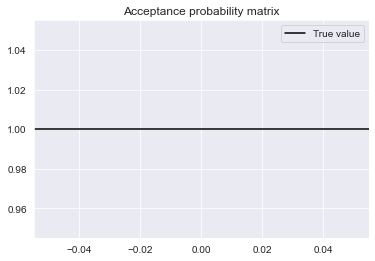

<Figure size 432x288 with 0 Axes>

In [103]:
plt.plot(, 'forestgreen')
plt.axhline(1, color = 'black', label = 'True value')
plt.legend()
plt.title('Acceptance probability matrix')
plt.show()
plt.savefig('documents/thesis/c05.png', dpi = 3000)

In [15]:
import matplotlib.pyplot as plt

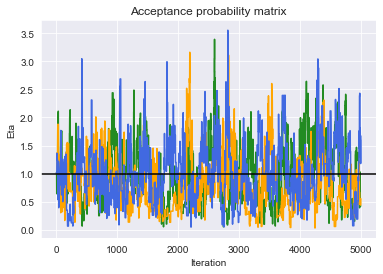

In [104]:
aaxis = np.arange(5000)
plt.plot(aaxis, intc_final10_1[:, 0]*intc_final10_1[:, 3], 'forestgreen', 
         aaxis, intc_final10_2[:, 0]*intc_final10_2[:, 3], 'orange', 
        aaxis, intc_final10_3[:, 0]*intc_final10_3[:, 3], 'royalblue',)
plt.axhline(1, color = 'black', label = 'True value')
plt.xlabel("Iteration")
plt.ylabel("Eta")
#plt.legend(('Chain 1', 'Chain 2', 'Chain 3', 'True value'), bbox_to_anchor=(0.8, 0.8))
plt.title('Acceptance probability matrix')
plt.savefig('documents/thesis/yaaay.png', dpi = 300)

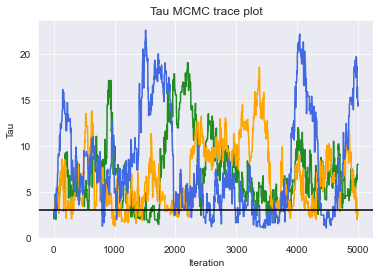

In [89]:
aaxis = np.arange(5000)
plt.plot(aaxis, intc_final10_1[:, 1]+1, 'forestgreen', 
         aaxis, intc_final10_2[:, 1]+1, 'orange', 
        aaxis, intc_final10_3[:, 1]+1, 'royalblue',)
plt.axhline(3, color = 'black', label = 'True value')
plt.xlabel("Iteration")
plt.ylabel("Tau")
#plt.legend(('Chain 1', 'Chain 2', 'Chain 3', 'True value'), bbox_to_anchor=(0.8, 0.8))
plt.title('Tau MCMC trace plot')
plt.savefig('documents/thesis/tau_final10.png', dpi = 300)

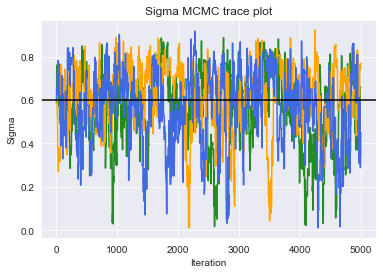

In [90]:
aaxis = np.arange(5000)
plt.plot(aaxis, intc_final10_1[:, 2], 'forestgreen', 
         aaxis, intc_final10_2[:, 2], 'orange', 
        aaxis, intc_final10_3[:, 2], 'royalblue',)
plt.axhline(0.6, color = 'black', label = 'True value')
plt.xlabel("Iteration")
plt.ylabel("Sigma")
#plt.legend(('Chain 1', 'Chain 2', 'Chain 3', 'True value'), bbox_to_anchor=(0.8, 0.8))
plt.title('Sigma MCMC trace plot')
plt.savefig('documents/thesis/sigma_final10.png', dpi = 300)

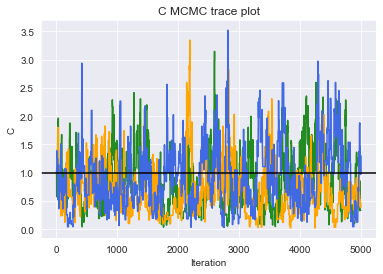

In [91]:
aaxis = np.arange(5000)
plt.plot(aaxis, intc_final10_1[:, 3], 'forestgreen', 
         aaxis, intc_final10_2[:, 3], 'orange', 
        aaxis, intc_final10_3[:, 3], 'royalblue')
plt.axhline(1, color = 'black', label = 'True value')
plt.xlabel("Iteration")
plt.ylabel("C")
#plt.legend(('Chain 1', 'Chain 2', 'Chain 3', 'True value'), bbox_to_anchor=(1, 1))
plt.title('C MCMC trace plot')
plt.savefig('documents/thesis/c_final10.png', dpi = 300)

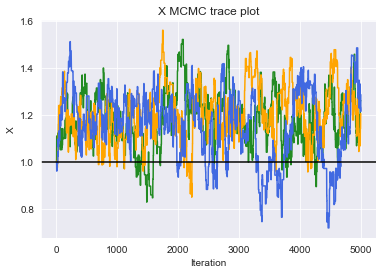

In [92]:
aaxis = np.arange(5000)
plt.plot(aaxis, intc_final10_1[:, 0], 'forestgreen', 
         aaxis, intc_final10_2[:, 0], 'orange', 
        aaxis, intc_final10_3[:, 0], 'royalblue')
plt.axhline(1, color = 'black', label = 'True value')
plt.xlabel("Iteration")
plt.ylabel("X")
#plt.legend(('Chain 1', 'Chain 2', 'Chain 3', 'True value'), bbox_to_anchor=(1, 1))
plt.title('X MCMC trace plot')
plt.savefig('documents/thesis/x_final10.png', dpi = 300)

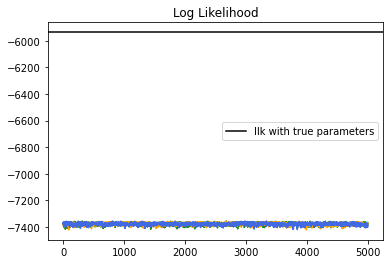

<Figure size 432x288 with 0 Axes>

In [94]:
plt.plot(intc_fin2_1[1:5000, 4], 'forestgreen')
plt.plot(intc_fin2_2[1:5000, 4], 'orange')
plt.plot(intc_fin2_3[1:5000, 4], 'royalblue')
plt.axhline(-5935, color = 'black', label = 'llk with true parameters')
plt.legend()
plt.title('Log Likelihood')
plt.show()
plt.savefig('documents/thesis/final_llk.png', dpi = 1000)


In [106]:
import numpy as np
np.savetxt('documents/thesis/finalf_matrixfinal1.csv', intc_final10_1, delimiter = ',')
np.savetxt('documents/thesis/finalf_matrixfinal2.csv', intc_final10_2, delimiter = ',')
np.savetxt('documents/thesis/finalf_matrixfinal3.csv', intc_final10_3, delimiter = ',')
np.savetxt('documents/thesis/finalf_data_final.csv', y_new, delimiter = ',')

In [93]:
intc_fin2_combined = np.concatenate((intc_final10_1, intc_final10_2, intc_final10_3))

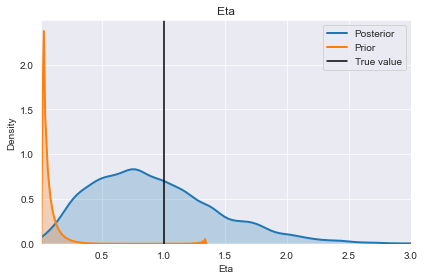

In [94]:
import seaborn as sns
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,3]*intc_fin2_combined[:,0], label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 50000000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(1, color = "black", label='True value')
plt.title('Eta')
plt.xlabel("Eta")
plt.ylabel("Density")
plt.xlim(0.01, 3)
plt.legend()
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_eta_10.png', dpi = 300)

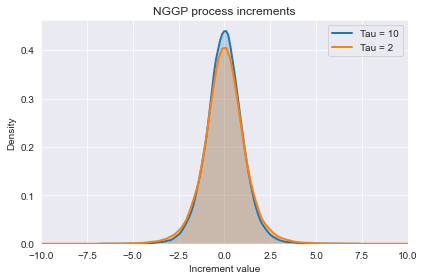

In [140]:
sns.distplot(y_new, label = 'Tau = 10', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
sns.distplot(y_new2, label = 'Tau = 2', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.title('NGGP process increments')
plt.xlabel("Increment value")
plt.ylabel("Density")
plt.xlim(-10, 10)
plt.legend()
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_increments.png', dpi = 300)

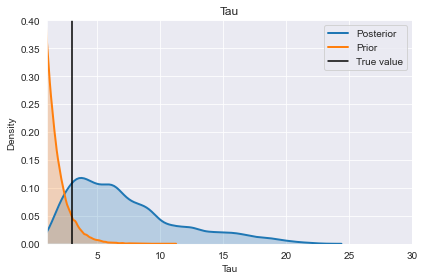

In [95]:
import seaborn as sns
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,1]+1, label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 50000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(3, color = "black", label='True value')
plt.xlim(1.01, 30)
plt.ylim(0, 0.4)
plt.xlabel("Tau")
plt.ylabel("Density")
plt.title('Tau')
plt.legend()
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_tau_10.png', dpi = 300)

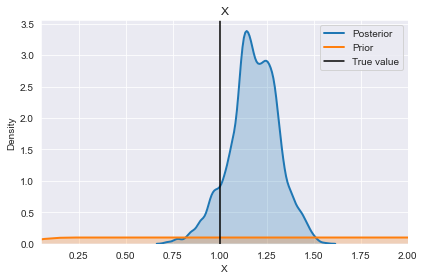

In [96]:
import seaborn as sns
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,0], label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.uniform.rvs(loc = 0, scale = 10, size = 50000000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(1, color = "black", label='True value')
plt.xlim(0.05, 2)
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.title('X')
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_x_10.png', dpi = 300)

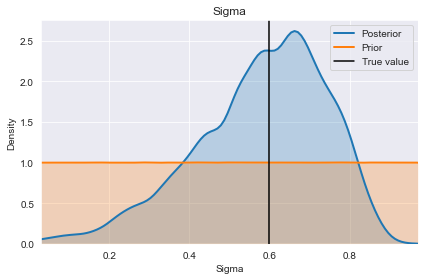

In [97]:
import seaborn as sns
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,2], label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.uniform.rvs(loc = 0, scale = 1, size = 50000000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(0.6, color = "black", label='True value')
plt.xlim(0.03, 0.97)
plt.xlabel("Sigma")
plt.ylabel("Density")
plt.legend()
plt.title('Sigma')
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_sigma_10.png', dpi = 300)

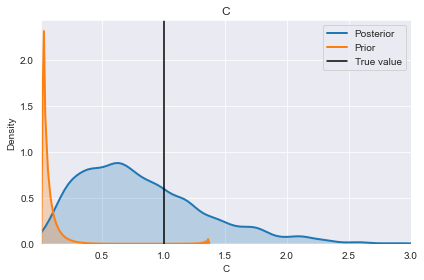

In [100]:
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,3], label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 50000000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(1, color = "black", label='True value')
plt.xlim(0.01, 3)
plt.legend()
plt.title('C')
plt.xlabel("C")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_c_10.png', dpi = 300)

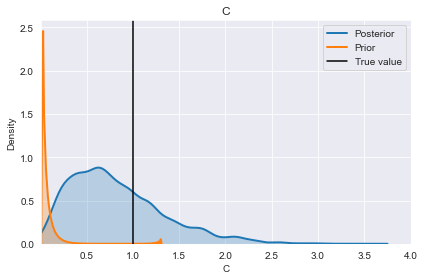

In [99]:
sns.set_style("darkgrid")
sns.distplot(intc_fin2_combined[:,3], label = 'Posterior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
data = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 50000000)
sns.distplot(data, label = 'Prior', kde = True, hist = False, kde_kws={"shade": "True", "lw": 2, "label": "KDE"})
plt.axvline(1, color = "black", label='True value')
plt.xlim(0.01, 4)
plt.xlabel("C")
plt.ylabel("Density")
plt.legend()
plt.title('C')
plt.tight_layout()
plt.savefig('documents/thesis/final_dist_c_10.png', dpi = 300)

In [ ]:
intc_fin_2 = mhmcmc(5000)

In [ ]:
intc_fin_3 = mhmcmc(5000)

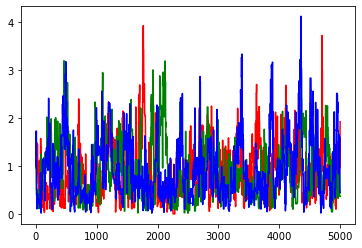

In [13]:
plt.plot(intc_fin_1[:, 3]*intc_fin_1[:, 1]*intc_fin_1[:, 0]/(intc_fin_1[:, 1]+1 - intc_fin_1[:, 2]), 'r')
plt.plot(intc_fin_2[:, 3]*intc_fin_2[:, 1]*intc_fin_2[:, 0]/(intc_fin_2[:, 1]+1 - intc_fin_2[:, 2]), 'g')
plt.plot(intc_fin_3[:, 3]*intc_fin_3[:, 1]*intc_fin_3[:, 0]/(intc_fin_3[:, 1]+1 - intc_fin_3[:, 2]), 'b')
plt.show()

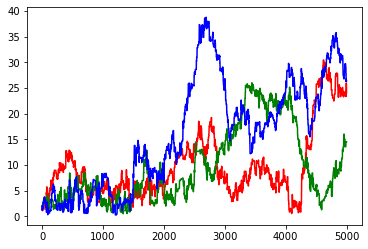

In [14]:
plt.plot(intc_fin_1[:, 1], 'r')
plt.plot(intc_fin_2[:, 1], 'g')
plt.plot(intc_fin_3[:, 1], 'b')
plt.show()

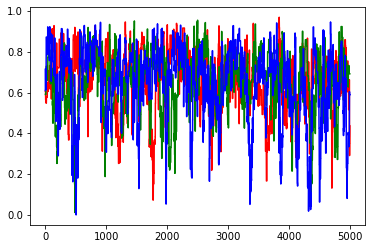

In [15]:
plt.plot(intc_fin_1[:, 2], 'r')
plt.plot(intc_fin_2[:, 2], 'g')
plt.plot(intc_fin_3[:, 2], 'b')
plt.show()

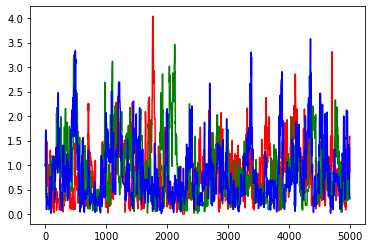

In [16]:
plt.plot(intc_fin_1[:, 3], 'r')
plt.plot(intc_fin_2[:, 3], 'g')
plt.plot(intc_fin_3[:, 3], 'b')
plt.show()

In [169]:
import time
from Downloads.PComputePreq import log_lik_normal_particless
import multiprocessing as mp

#eta_var = phi[3]*phi[1]*phi[0]/(phi[1]+1 - phi[2])
#eta_fraction = phi[0]*phi[3]

def log_lik_normal_particles(phi, particles):
    
    #start_time = time.time()
    
    v = np.zeros((particles, 5000))
    
    for i in range(0, particles, 1):
        
        v[i, 0:5000] = GBFRYsumrnd(eta = phi[0]*phi[3], tau = phi[1]+1, sigma = phi[2], c = phi[3], n = 5000)
        
    llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))
    
    #print(time.time() - start_time, 's')
    
    return llk

#def log_lik_normal_p(phi):
    
    #start_time = time.time()
    
#    pool = mp.Pool(4)
          
#    v = np.matrix(pool.starmap(log_lik_normal_particless, [(phi, i) for i in range(0,300)]))
    
#    pool.close()  
        
#    llk = sum(log(np.mean(stats.norm.pdf(x = y_new, loc = 0, scale = np.sqrt(v)), axis = 0)))
    
    #print(time.time() - start_time, 's')
    
#    return llk

def fraction(phi, phi_new):
    
    llknew = log_lik_normal_particles(phi_new, 25)
    llkold = log_lik_normal_particles(phi, 25)
    
    numerator = llknew + log(stats.uniform.pdf(phi_new[0], loc = 0, scale = 10)) + log(phi_new[0]) + log(stats.gamma.pdf(phi_new[1], a = 1, loc = 0, scale = 1)) + log(phi_new[1]) + log(stats.uniform.pdf(phi_new[2], loc = 0, scale = 1)) + log(phi_new[2]) + log(1-phi_new[2])+ log(stats.gamma.pdf(phi_new[3], a = 0.1, loc = 0, scale = 0.1)) + log(phi_new[3])
    
    denominator = llkold + log(stats.uniform.pdf(phi[0], loc = 0, scale = 10)) + log(phi[0]) + log(stats.gamma.pdf(phi[1], a = 1, loc = 0, scale = 1)) + log(phi[1]) + log(stats.uniform.pdf(phi[2], loc = 0, scale = 1)) + log(phi[2]) + log(1-phi[2])+ log(stats.gamma.pdf(phi[3], a = 0.1, loc = 0, scale = 0.1)) + log(phi[3])
    
    logfrac = numerator-denominator
    
    return logfrac, llknew, llkold


def acceptance(phi, phi_new):
    
    fr = fraction(phi, phi_new)
    
    if fr[0] > 0:
        cond = True
        
    else:
        acc = np.random.uniform(0,1)
        cond = (acc < (np.exp(fr[0])))
        
    llknew = fr[1]
    llkold = fr[2]
    
    return cond, llknew, llkold 

In [170]:
import random as rd

def mhmcmc(K):
    
    
    start_time = time.time()
    
    #halpha = hill_estimate(y_new, 50)[15:].mean()
    
    out = np.zeros((K, 5))

    phi = np.zeros(4)
    
    phi[0] = 1 + stats.norm(0, 0.01).rvs(size = 1)
    phi[1] = 2 +  stats.norm(0, 0.01).rvs(size = 1)
    phi[2] = 0.6 + stats.norm(0, 0.01).rvs(size = 1)
    phi[3] = 1 + stats.norm(0, 0.01).rvs(size = 1)
    

    out[0, 0:4] = phi
    

    for k in range(1,K,1):
        
        
        
        
        #print(phi)

        
        lis = [1]
        
        choice = rd.choice(lis)
        
        phi_new = np.zeros(4)
        
        if choice == 1:         
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0.05).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0.8).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0.1).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0.5).rvs(size = 1))
             
            
        if choice == 2: 
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 
            
        if choice == 3:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 

        if choice == 4:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1))
        
        #if phi_new[3] < 0:
        #    phi_new[3] = 0.0000000001
            
        
        #print(phi_new)
        #print(phi)
        
        #phi_new[0] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)    
            
      #  if choice == 2: 
        #phi_new[1] = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 1)
            
      #  if choice == 3:
        #phi_new[2] = stats.uniform.rvs(loc = 0, scale = 1, size = 1)

       # if choice == 4:
        #phi_new[3] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)
        
        

        acc = acceptance(phi, phi_new)
        #print(acc[1])
        #print(acc[2])
        
        #print('----------------------')

        if acc[0] is True:

            phi = phi_new 
            out[k, 4] = acc[1]

        else:

            phi = phi
            out[k, 4] = acc[2]

        out[k, 0:4] = phi

        if k == 1:
            print(1)
            print(time.time() - start_time, 's')
        
        if k == 10:
            print(10)
            print(time.time() - start_time, 's')
            
        if k == 50:
            print(50)
            print(time.time() - start_time, 's')
            
        if k == 100:
            print(100)
            print(time.time() - start_time, 's')
            
        if k == 200:
            print(200)
            print(time.time() - start_time, 's')
            
        if k == 300:
            print(300)
            print(time.time() - start_time, 's')
            
        if k == 400:
            print(400)
            print(time.time() - start_time, 's')
            
            
        if k == 1000:
            print(1000)
        if k == 4000:
            print(4000)
            
        if k == 8000:
            print(8000)
        
        
    print(time.time() - start_time, 's')
        
    return out



intc_fin_log_1 = mhmcmc(5000)

#c - 1, sigma - 0.1, tau - 0.2, var - 0.1 - tau was mixing very well 



1
1.2133898735046387 s
10
14.261205911636353 s
50
62.43399691581726 s
100
117.80236887931824 s
200
280.591903924942 s
300
514.5064659118652 s
400
743.8626129627228 s
1000
4000
6420.855069875717 s


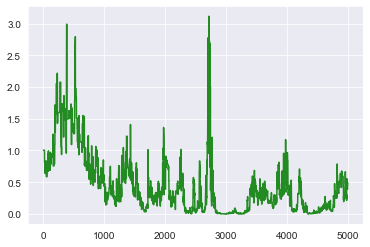

In [183]:
plt.plot(intc_fin_log_1[:, 0]*intc_fin_log_1[:, 3], 'forestgreen')

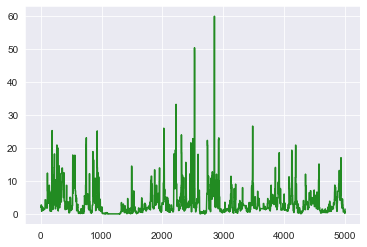

In [185]:
plt.plot(intc_fin_log_3[:, 1], 'forestgreen')

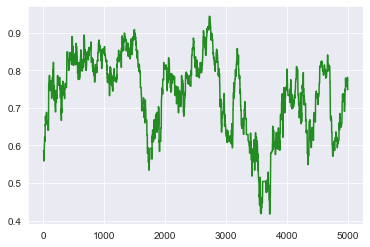

In [187]:
plt.plot(intc_fin_log_3[:, 2], 'forestgreen')

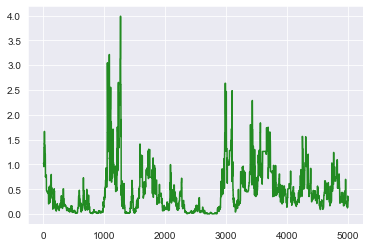

In [189]:
plt.plot(intc_fin_log_3[:, 3], 'forestgreen')

In [177]:
intc_fin_log_2 = mhmcmc(5000)

1
1.8301479816436768 s
10
14.7400062084198 s
50
58.67574214935303 s
100
117.93714022636414 s
200
245.95294213294983 s
300
387.710164308548 s
400
504.89083313941956 s
1000
4000
5705.181428909302 s


In [178]:
intc_fin_log_3 = mhmcmc(5000)

1
2.0748400688171387 s
10
15.086989879608154 s
50
79.53549480438232 s
100
126.26520872116089 s
200
203.04562973976135 s
300
263.27389001846313 s
400
325.1555027961731 s
1000
4000
4735.057144641876 s


Text(0.5, 1.0, 'C')

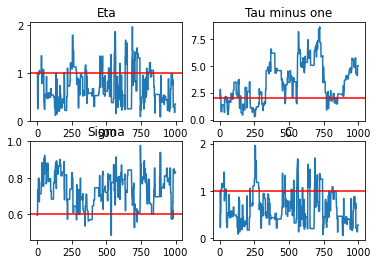

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(intc210[:, 3]*intc210[:, 1]*intc210[:, 0]/(intc210[:, 1]+1 - intc210[:, 2]))
axs[0,0].axhline(1, color = 'red', label = 'True value')
axs[0,0].set_title('Eta')
axs[0,1].plot(intc210[:, 1])
axs[0,1].axhline(2, color = 'red', label = 'True value')
axs[0,1].set_title('Tau minus one')
axs[1,0].plot(intc210[:, 2])
axs[1,0].axhline(0.6, color = 'red', label = 'True value')
axs[1,0].set_title('Sigma')
axs[1,1].plot(intc210[:, 3])
axs[1,1].axhline(1, color = 'red', label = 'True value')
axs[1,1].set_title('C')
#plt.plot(intc[1:, 4])
#plt.axhline(1, color = 'red', label = 'True value')
#plt.legend()
#plt.savefig('documents/thesis/5000its_looks_good.png', dpi = 1000)

In [41]:
import pickle
data = pickle.load(open('Downloads/chain.pkl', "rb"))

In [39]:
print(data)

In [31]:
np.savetxt('documents/thesis/500runs_5000obs_100p_all_corr.csv', intc, delimiter = ',')
np.savetxt('documents/thesis/500runs_5000obs_100p_all_corrDATA.csv', y_new, delimiter = ',')

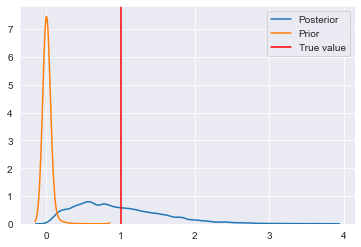

In [54]:
import seaborn as sns
sns.set_style("darkgrid")
sns.kdeplot(intc15[:,3]*intc15[:,0], label = 'Posterior', bw = 0.05)
data = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 5000)
sns.kdeplot(data, label = 'Prior', bw = 0.05)
plt.axvline(1, color = "red", label='True value')
plt.legend()
#plt.savefig('documents/thesis/0101stdratio_all_500its_eta_dist.png', dpi = 1000)

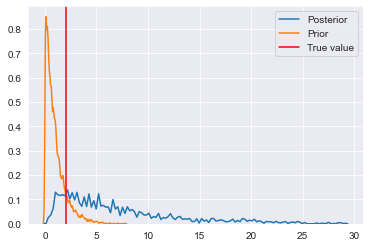

In [55]:
sns.set_style("darkgrid")
sns.kdeplot(intc15[:, 1], label = 'Posterior', bw = 0.05)
data = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 5000)
sns.kdeplot(data, label = 'Prior', bw = 0.05)
plt.axvline(2, color = "red", label='True value')
plt.legend()
#plt.savefig('documents/thesis/0101stdratio_all_500its_tau_dist.png', dpi = 1000)

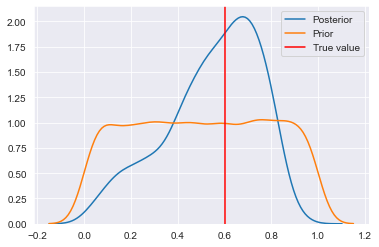

In [56]:
sns.set_style("darkgrid")
sns.kdeplot(intc15[:, 2], label = 'Posterior', bw = 0.05)
data = stats.uniform.rvs(loc = 0, scale = 1, size = 5000)
sns.kdeplot(data, label = 'Prior', bw = 0.05)
plt.axvline(0.6, color = "red", label='True value')
plt.legend()
#plt.savefig('documents/thesis/0101stdratio_all_500its_sigma_dist.png', dpi = 1000)

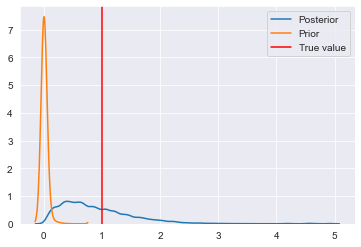

In [57]:
sns.set_style("darkgrid")
sns.kdeplot(intc15[:, 3], label = 'Posterior', bw = 0.05)
data = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 10000)
sns.kdeplot(data, label = 'Prior', bw = 0.05)
plt.axvline(1, color = "red", label='True value')
plt.legend()
#plt.savefig('documents/thesis/0101stdratio_all_500its_c_dist.png', dpi = 1000)

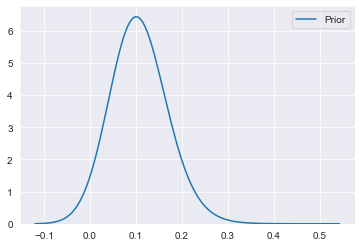

In [335]:
data = exp(stats.norm(log(0.1), 0.35).rvs(size = 10000))
sns.kdeplot(data, label = 'Prior', bw = 0.05)

In [206]:
m = [
    [0.02%, 0.00%, 0.00%, 0.00%],
    [0.00%, 75.44%, 0.00%, 0.00%],
    [0.00%, 0.00%, 100.00%, 0.00%],
    [0.00%, 0.00%, 00.00%, 11.64%],
]


SyntaxError: invalid syntax (<ipython-input-206-b775d81eacc9>, line 2)

0.2689414213699951

In [52]:
kkk = 0.6

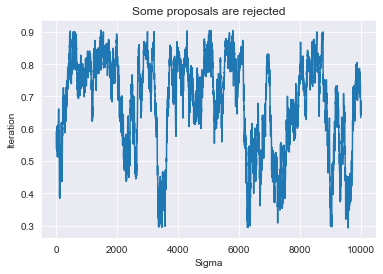

In [53]:
collected = np.zeros(10000)
for i in range(0, 10000):
    if kkk < 0.9:
        if kkk > 0.3:
            kkk = sigmoid(stats.norm(logit(kkk), 0.07).rvs(size = 1))
        else: kkk = 0.4
    else: kkk = 0.8
    collected[i] = kkk
plt.plot(collected)
plt.xlabel("Sigma")
plt.ylabel("Iteration")
plt.title('Some proposals are rejected')
plt.savefig('documents/thesis/sigmaproposalgood', dpi = 1000)

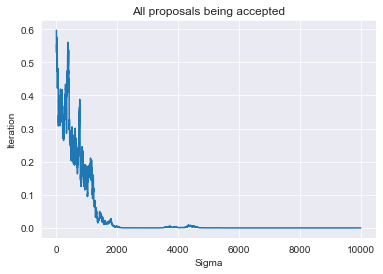

In [48]:
collected = np.zeros(10000)
for i in range(0, 10000):
    kkk = sigmoid(stats.norm(logit(kkk), 0.07).rvs(size = 1))
    collected[i] = kkk
plt.plot(collected)
plt.xlabel("Sigma")
plt.ylabel("Iteration")
plt.title('All proposals being accepted')
plt.savefig('documents/thesis/sigmaproposalbad', dpi = 1000)

In [49]:
kkk = 0.6

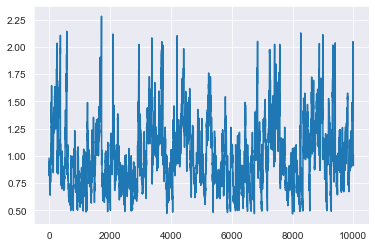

In [358]:
collected = np.zeros(10000)
for i in range(0, 10000):
    if kkk < 2:
        if kkk > 0.5:
            kkk = exp(stats.norm(log(kkk), 0.05).rvs(size = 1))
        else: kkk = 1
    else: kkk = 1
    collected[i] = kkk
plt.plot(collected)


In [382]:
exp(0.5)-log(0.6)

2.1595468944661187

In [383]:
exp(0.6)-log(0.5)

2.515265980950454

In [384]:
stats.norm.pdf(log(0.6),loc = log(0.5), scale = 1)

0.3923664288891069

In [385]:
stats.norm.pdf(log(0.5),loc = log(0.6), scale = 1)

0.3923664288891069

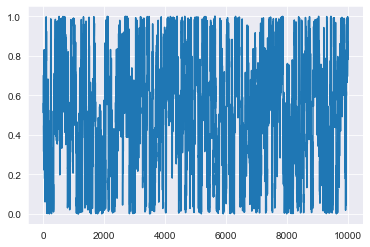

In [390]:
kkk=0.6
collected = np.zeros(10000)
for i in range(0, 10000):    
    kkk = abs(stats.norm(kkk, 0.1).rvs(size = 1))
    if 1 < kkk < 2 :
        kkk = 2 - kkk
    if 2 < kkk < 3 :
        kkk = 3 - kkk
    if 3 < kkk < 4 :
        kkk = 4 - kkk
    if 4 < kkk < 5 :
        kkk = 5 - kkk
    collected[i] = kkk
plt.plot(collected)

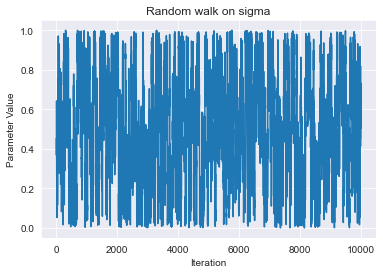

In [57]:
kkk=0.6
collected = np.zeros(10000)
for i in range(0, 10000):    
    kkk_new = stats.norm(kkk, 0.1).rvs(size = 1)
    if 0 < kkk_new < 1:
        kkk = kkk_new
    collected[i] = kkk
plt.plot(collected)
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.title('Random walk on sigma')
plt.savefig('documents/thesis/sigmapropnew.png', dpi = 1000)


In [201]:
import random as rd

def mhmcmc(K):
    
    
    start_time = time.time()
    
    #halpha = hill_estimate(y_new, 50)[15:].mean()
    
    out = np.zeros((K, 5))

    phi = np.zeros(4)
    
    phi[0] = 0.5 + stats.norm(0, 0.01).rvs(size = 1)
    phi[1] = 2 +  stats.norm(0, 0.01).rvs(size = 1)
    phi[2] = 0.6 + stats.norm(0, 0.01).rvs(size = 1)
    phi[3] = 1 + stats.norm(0, 0.01).rvs(size = 1)
    

    out[0, 0:4] = phi
    

    for k in range(1,K,1):
        
        
        
        
        #print(phi)

        
        lis = [1]
        
        choice = rd.choice(lis)
        
        phi_new = np.zeros(4)
        
        if choice == 1:         
            phi_new[0] = abs(stats.norm(phi[0], 0.1).rvs(size = 1))
#           if phi_new[0] < 0:
#                phi_new[0] = 0.000001
            phi_new[1] = abs(stats.norm(phi[1], 0.1).rvs(size = 1))
#            if phi_new[1] < 0:
#                phi_new[1] = 0.000001
            phi_new[2] = abs(stats.norm(phi[2], 0.1).rvs(size = 1))
            if 1 < phi_new[2] < 2 :
                phi_new[2] = 2 - phi_new[2]
            if 2 < phi_new[2] < 3 :
                phi_new[2] = 3 - phi_new[2]
            if 3 < phi_new[2] < 4 :
                phi_new[2] = 4 - phi_new[2]
            if 4 < phi_new[2] < 5 :
                phi_new[2] = 5 - phi_new[2]
            phi_new[3] = abs(stats.norm(phi[3], 0.1).rvs(size = 1))
#            if phi_new[3] < 0:
#                phi_new[3] = 0.000001
             
            
        if choice == 2: 
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 
            
        if choice == 3:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1)) 

        if choice == 4:
            phi_new[0] = math.exp(stats.norm(log(phi[0]), 0).rvs(size = 1))
            phi_new[1] = math.exp(stats.norm(log(phi[1]), 0).rvs(size = 1))
            phi_new[2] = sigmoid(stats.norm(logit(phi[2]), 0).rvs(size = 1))
            phi_new[3] = math.exp(stats.norm(log(phi[3]), 0).rvs(size = 1))
        
        #if phi_new[3] < 0:
        #    phi_new[3] = 0.0000000001
            
        
        #print(phi_new)
        #print(phi)
        
        #phi_new[0] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)    
            
      #  if choice == 2: 
        #phi_new[1] = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 1)
            
      #  if choice == 3:
        #phi_new[2] = stats.uniform.rvs(loc = 0, scale = 1, size = 1)

       # if choice == 4:
        #phi_new[3] = stats.gamma.rvs(a = 0.1, loc = 0, scale = 0.1, size = 1)
        
        

        acc = acceptance(phi, phi_new)
        #print(acc[1])
        #print(acc[2])
        
        #print('----------------------')

        if acc[0] is True:

            phi = phi_new 
            out[k, 4] = acc[1]

        else:

            phi = phi
            out[k, 4] = acc[2]

        out[k, 0:4] = phi

        if k == 1:
            print(1)
            print(time.time() - start_time, 's')
        
        if k == 10:
            print(10)
            print(time.time() - start_time, 's')
            
        if k == 50:
            print(50)
            print(time.time() - start_time, 's')
            
        if k == 100:
            print(100)
            print(time.time() - start_time, 's')
            
        if k == 200:
            print(200)
            print(time.time() - start_time, 's')
            
        if k == 300:
            print(300)
            print(time.time() - start_time, 's')
            
        if k == 400:
            print(400)
            print(time.time() - start_time, 's')
            
            
        if k == 1000:
            print(1000)
        if k == 4000:
            print(4000)
            
        if k == 8000:
            print(8000)
        
        
    print(time.time() - start_time, 's')
        
    return out


intc_test_3 = mhmcmc(1000)

#c - 1, sigma - 0.1, tau - 0.2, var - 0.1 - tau was mixing very well 


1
1.0614361763000488 s
10
10.792910099029541 s
50
50.656095027923584 s
100
90.88850617408752 s
200
179.55400919914246 s
300
272.3142693042755 s
400
377.2900562286377 s
1107.281571149826 s
